# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

feat_summary = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

print(feat_summary)

                attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
11            GEBURTSJAHR            person      numeric                [0]
12        GF

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print(azdias.head(10))
print(azdias.columns.tolist())

print(feat_info)



   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   
5         3                     1          2            2.0   
6        -1                     2          2            5.0   
7        -1                     1          1            3.0   
8        -1                     3          1            3.0   
9        -1                     3          2            4.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3             

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
def missing_splited(missing_or_unknown):
    new_list=list()
    for values in missing_or_unknown:
        #print(values[1:-1])
        new_list.append(values[1:-1].split(","))
        #print(values)
    return new_list

missing_values=missing_splited(feat_info["missing_or_unknown"])

for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            #check if the missing value is number (negative or positive numbers)
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                missing_value = int(missing_value)
            
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

AGER_TYP: 76.96%
ALTERSKATEGORIE_GROB: 0.32%
ANREDE_KZ: 0.00%
CJT_GESAMTTYP: 0.54%
FINANZ_MINIMALIST: 0.00%
FINANZ_SPARER: 0.00%
FINANZ_VORSORGER: 0.00%
FINANZ_ANLEGER: 0.00%
FINANZ_UNAUFFAELLIGER: 0.00%
FINANZ_HAUSBAUER: 0.00%
FINANZTYP: 0.00%
GEBURTSJAHR: 44.02%
GFK_URLAUBERTYP: 0.54%
GREEN_AVANTGARDE: 0.00%
HEALTH_TYP: 12.48%
LP_LEBENSPHASE_FEIN: 10.95%
LP_LEBENSPHASE_GROB: 10.61%
LP_FAMILIE_FEIN: 8.73%
LP_FAMILIE_GROB: 8.73%
LP_STATUS_FEIN: 0.54%
LP_STATUS_GROB: 0.54%
NATIONALITAET_KZ: 12.15%
PRAEGENDE_JUGENDJAHRE: 12.14%
RETOURTYP_BK_S: 0.54%
SEMIO_SOZ: 0.00%
SEMIO_FAM: 0.00%
SEMIO_REL: 0.00%
SEMIO_MAT: 0.00%
SEMIO_VERT: 0.00%
SEMIO_LUST: 0.00%
SEMIO_ERL: 0.00%
SEMIO_KULT: 0.00%
SEMIO_RAT: 0.00%
SEMIO_KRIT: 0.00%
SEMIO_DOM: 0.00%
SEMIO_KAEM: 0.00%
SEMIO_PFLICHT: 0.00%
SEMIO_TRADV: 0.00%
SHOPPER_TYP: 12.48%
SOHO_KZ: 8.25%
TITEL_KZ: 99.76%
VERS_TYP: 12.48%
ZABEOTYP: 0.00%
ALTER_HH: 34.81%
ANZ_PERSONEN: 8.25%
ANZ_TITEL: 8.25%
HH_EINKOMMEN_SCORE: 2.06%
KK_KUNDENTYP: 65.60%
W_KEIT_KIND

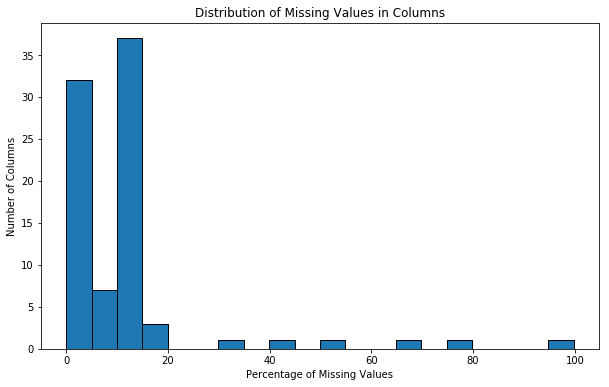

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Calculate the percentage of missing values in each column
missing_percentage = (azdias.isnull().sum() / len(azdias)) * 100

# Print column names and their respective percentages of missing values
for column, percentage in zip(missing_percentage.index, missing_percentage):
    print(f"{column}: {percentage:.2f}%")
    
# Step 2: Visualize the distribution of missing values using a histogram
plt.figure(figsize=(10, 6))
plt.hist(missing_percentage, bins=20, edgecolor='black')
plt.title('Distribution of Missing Values in Columns')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show()


In [6]:
# Investigate patterns in the amount of missing data in each column.
import pandas as pd

# Assuming df is your DataFrame
correlation_threshold = 0.8  # Adjust the threshold as needed

# Calculate the correlation matrix between missing values
correlation_matrix = azdias.isnull().corr()

# Find pairs of columns with correlation above the threshold
highly_correlated_pairs = (
    (correlation_matrix > correlation_threshold) & (correlation_matrix < 1)
).stack().reset_index()

# Filter to get only the pairs with high correlation
highly_correlated_pairs = highly_correlated_pairs[highly_correlated_pairs[0]]

highly_correlated_pairs = highly_correlated_pairs.merge(feat_summary, how='inner', left_on= "level_0", right_on = "attribute")

distinct_values = highly_correlated_pairs.groupby(['level_0', 'information_level']).size().reset_index(name='Count').sort_values(by="Count", ascending=False)

# Print the distinct values in the "Level_0" column
#print("Distinct Values in Level_0:")
print(distinct_values)



                  level_0 information_level  Count
19       KBA13_ANZAHL_PKW    macrocell_plz8     34
11     GEBAEUDETYP_RASTER        region_rr1     34
5                BALLRAUM          postcode     32
6         CAMEO_DEUG_2015     microcell_rr4     32
7          CAMEO_DEU_2015     microcell_rr4     32
8         CAMEO_INTL_2015     microcell_rr4     32
9                EWDICHTE          postcode     32
13             INNENSTADT          postcode     32
43               WOHNLAGE          building     31
29            OST_WEST_KZ          building     31
25       MIN_GEBAEUDEJAHR          building     31
10            GEBAEUDETYP          building     31
28            ORTSGR_KLS9         community     28
1            ANZ_HH_TITEL          building     28
0     ANZ_HAUSHALTE_AKTIV          building     28
38               RELAT_AB         community     27
4                  ARBEIT         community     27
30             PLZ8_ANTG1    macrocell_plz8     23
20            KONSUMNAEHE      

In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Assuming df is your DataFrame
threshold = 20  # Adjust the threshold as needed (e.g., 30% missing values)

# Step 1: Calculate the percentage of missing values in each column
missing_percentage = (azdias.isnull().sum() / len(azdias)) * 100

# Step 2: Identify columns with missing values above the threshold
outlier_columns = missing_percentage[missing_percentage > threshold].index

# Step 3: Remove outlier columns from the DataFrame
azdias_cleaned = azdias.drop(columns=outlier_columns)

# Print the list of removed columns
print("Removed outlier columns:")
print(outlier_columns)

Removed outlier columns:
Index(['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP',
       'KBA05_BAUMAX'],
      dtype='object')


#### Discussion 1.1.2: Assess Missing Data in Each Column

From my analysis, there appears to be a null correlation when certain non-person attributes are also null.  Using a null threshold of 20% I removed the columns printed in the output above from the dataframe.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

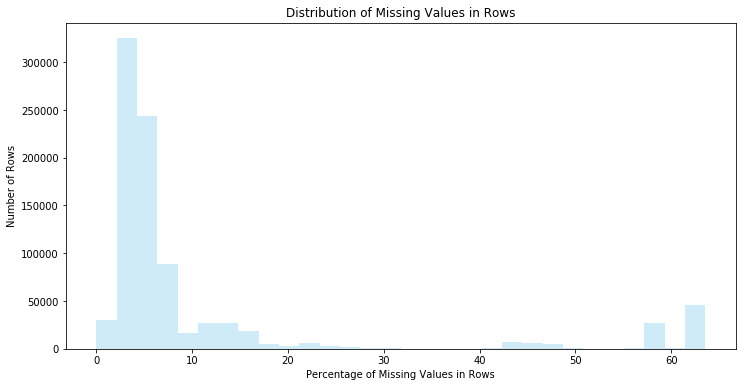

In [8]:
# How much data is missing in each row of the dataset?

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming Azdias is your DataFrame
row_missing_percentage = azdias.isnull().mean(axis=1) * 100

# Plot the distribution of missing values in rows
plt.figure(figsize=(12, 6))
sns.distplot(row_missing_percentage, bins=30, kde=False, color='skyblue')
plt.title('Distribution of Missing Values in Rows')
plt.xlabel('Percentage of Missing Values in Rows')
plt.ylabel('Number of Rows')
plt.show()


In [9]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Assuming azdias is your DataFrame
row_missing_count = azdias.isnull().sum(axis=1)

# Set a threshold for the number of missing values in rows
missing_count_threshold = 20  # Adjust the threshold as needed

# Create two subsets based on the threshold
rows_below_threshold = azdias[row_missing_count <= missing_count_threshold]
rows_above_threshold = azdias[row_missing_count > missing_count_threshold]


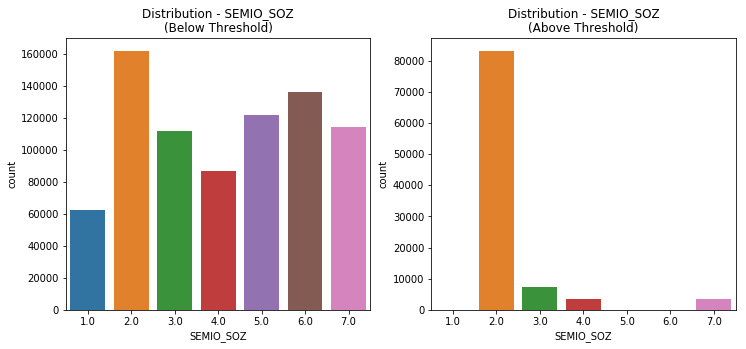

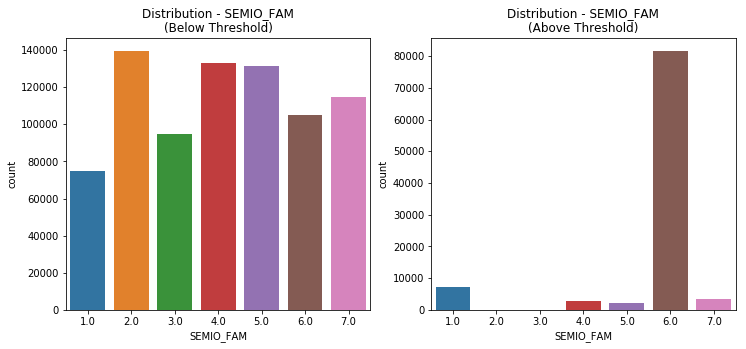

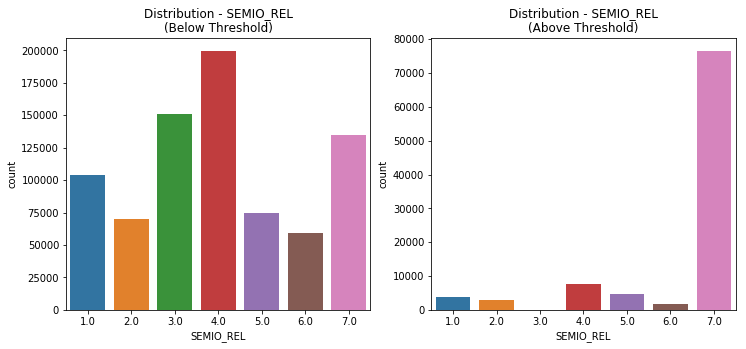

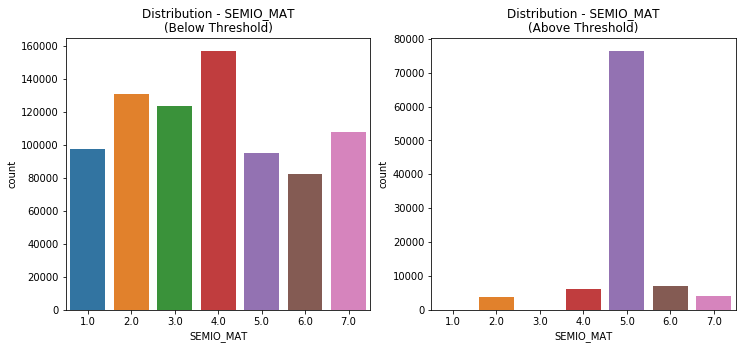

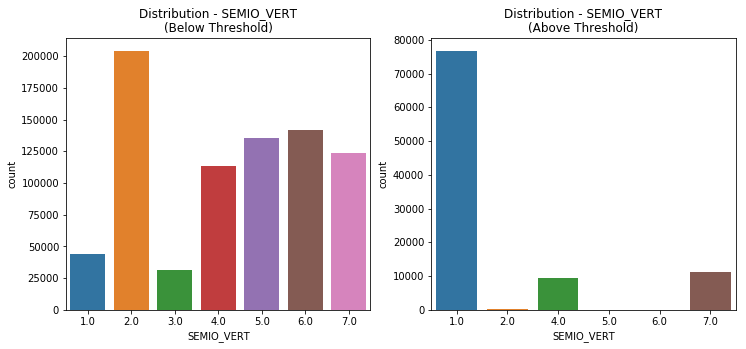

In [10]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

import seaborn as sns
import matplotlib.pyplot as plt

# Assuming azdias is your DataFrame
selected_columns = ['SEMIO_SOZ','SEMIO_FAM','SEMIO_REL','SEMIO_MAT','SEMIO_VERT']
subset_labels = ['Below Threshold', 'Above Threshold']

def compare_distributions(column):
    plt.figure(figsize=(12, 5))

    for i, subset in enumerate([rows_below_threshold, rows_above_threshold]):
        plt.subplot(1, 2, i+1)
        sns.countplot(x=column, data=subset)
        plt.title(f'Distribution - {column}\n({subset_labels[i]})')

    plt.show()

# Compare distributions for each selected column
for column in selected_columns:
    compare_distributions(column)


#### Discussion 1.1.3: Assess Missing Data in Each Row

It looks like they are qualitatively different.  The distribution of the data in the below threshold dataframe has consistent distribution across all values (1-7).  The dirtsibution of data above the threshold shows an uneven pattern with often missing values.  

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [11]:
# How many features are there of each data type?

# Assuming feat_info is your feature summary DataFrame

# Count the number of features for each data type
feature_type_counts = feat_info['type'].value_counts()

# Print the result
print("Number of features for each data type:")
print(feature_type_counts)


Number of features for each data type:
ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [12]:
# Assuming azdias is your cleaned dataset and feat_info is your feature summary DataFrame
# Replace 'azdias' with the actual name of your cleaned dataset

azdias = rows_below_threshold
# Create an empty list to store columns to be re-encoded
columns_to_reencode = []

# Filter out only categorical features from the feature summary
categorical_features = feat_info[feat_info['type'] == 'categorical']['attribute']

# Assess each categorical feature
for feature in categorical_features:
    # Check if the column exists in the cleaned dataset
    if feature in azdias.columns:
        unique_values = azdias[feature].unique()
        num_unique = len(unique_values)

        # Print information about the categorical feature
        print(f"Feature: {feature}")
        print(f"Unique Values: {unique_values}")
        print(f"Number of Unique Values: {num_unique}")

        # Determine if the feature is binary or multi-level
        if num_unique == 2:
            print("Type: Binary")
        elif num_unique > 2:
            print("Type: Multi-level")
            # Append the feature name to the list if re-encoding is needed
            columns_to_reencode.append(feature)
        else:
            print("Type: Unknown")

        # Decide if re-encoding is needed (you can customize this based on your criteria)
        if num_unique > 2:
            print("Re-encoding: Yes")
        else:
            print("Re-encoding: No")

        print("\n" + "="*50 + "\n")
    else:
        print(f"Skipped feature {feature} as it is not present in the cleaned dataset.\n")

# Print the list of columns to be re-encoded
print("Columns to be Re-encoded:")
print(columns_to_reencode)

# Assuming azdias is your cleaned dataset and columns_to_reencode is the list of columns to be re-encoded
# Replace 'azdias' and 'columns_to_reencode' with the actual names

# Create a copy of the dataset to avoid modifying the original
azdias_encoded = azdias.copy()

# Perform one-hot encoding for each categorical feature in columns_to_reencode
for feature in columns_to_reencode:
    encoded_feature = pd.get_dummies(azdias[feature], prefix=feature, drop_first=True)
    azdias_encoded = pd.concat([azdias_encoded, encoded_feature], axis=1)
    azdias_encoded.drop(columns=[feature], inplace=True)

# Print the updated dataset
print(azdias_encoded.head())



Feature: AGER_TYP
Unique Values: [ nan   2.   3.   1.]
Number of Unique Values: 4
Type: Multi-level
Re-encoding: Yes


Feature: ANREDE_KZ
Unique Values: [ 2.  1.]
Number of Unique Values: 2
Type: Binary
Re-encoding: No


Feature: CJT_GESAMTTYP
Unique Values: [  5.   3.   2.   4.   1.   6.  nan]
Number of Unique Values: 7
Type: Multi-level
Re-encoding: Yes


Feature: FINANZTYP
Unique Values: [ 1.  6.  5.  2.  4.  3.]
Number of Unique Values: 6
Type: Multi-level
Re-encoding: Yes


Feature: GFK_URLAUBERTYP
Unique Values: [ 10.   1.   5.  12.   9.   3.   8.  11.   4.   7.   2.   6.  nan]
Number of Unique Values: 13
Type: Multi-level
Re-encoding: Yes


Feature: GREEN_AVANTGARDE
Unique Values: [0 1]
Number of Unique Values: 2
Type: Binary
Re-encoding: No


Feature: LP_FAMILIE_FEIN
Unique Values: [  5.   1.  nan  10.   2.   7.  11.   8.   4.   6.   9.   3.]
Number of Unique Values: 12
Type: Multi-level
Re-encoding: Yes


Feature: LP_FAMILIE_GROB
Unique Values: [  3.   1.  nan   5.   2.   4.]


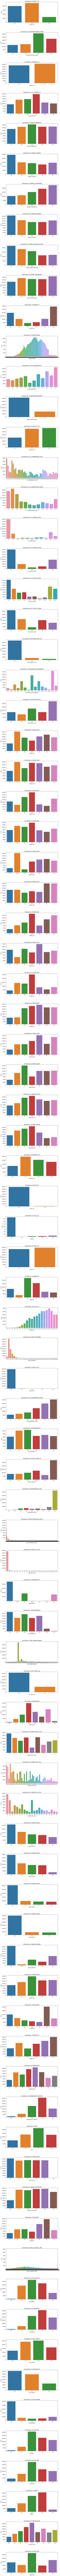

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns


# Set up subplots
fig, axes = plt.subplots(nrows=len(azdias.columns), figsize=(10, 6 * len(azdias.columns)))
fig.subplots_adjust(hspace=0.5)

# Plot distribution for each feature
for i, column in enumerate(azdias.columns):
    sns.countplot(x=column, data=azdias, ax=axes[i])
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Count')

plt.show()


In [14]:

# Set the threshold percentage (e.g., 80%)
threshold_percentage = 90

# Calculate the frequency of the most common value in each column
value_frequencies = azdias_encoded.apply(lambda x: x.value_counts().max() / len(x) * 100)

# Identify columns where the most common value frequency is above the threshold
columns_to_drop = value_frequencies[value_frequencies > threshold_percentage].index.tolist()

# Display the list of columns to drop
print("Columns to Drop:")
print(columns_to_drop)

# Drop columns identified for removal
azdias_encoded = azdias_encoded.drop(columns=columns_to_drop)

# Display the updated DataFrame
print("Updated DataFrame:")
print(azdias_encoded.head())



Columns to Drop:
['SOHO_KZ', 'ANZ_TITEL', 'ANZ_HH_TITEL', 'AGER_TYP_3.0', 'FINANZTYP_3.0', 'FINANZTYP_4.0', 'GFK_URLAUBERTYP_2.0', 'GFK_URLAUBERTYP_3.0', 'GFK_URLAUBERTYP_4.0', 'GFK_URLAUBERTYP_5.0', 'GFK_URLAUBERTYP_6.0', 'GFK_URLAUBERTYP_7.0', 'GFK_URLAUBERTYP_9.0', 'GFK_URLAUBERTYP_11.0', 'LP_FAMILIE_FEIN_3.0', 'LP_FAMILIE_FEIN_4.0', 'LP_FAMILIE_FEIN_5.0', 'LP_FAMILIE_FEIN_6.0', 'LP_FAMILIE_FEIN_7.0', 'LP_FAMILIE_FEIN_8.0', 'LP_FAMILIE_FEIN_9.0', 'LP_FAMILIE_FEIN_11.0', 'LP_FAMILIE_GROB_3.0', 'LP_FAMILIE_GROB_4.0', 'LP_STATUS_FEIN_3.0', 'LP_STATUS_FEIN_4.0', 'LP_STATUS_FEIN_5.0', 'LP_STATUS_FEIN_6.0', 'LP_STATUS_FEIN_7.0', 'LP_STATUS_FEIN_8.0', 'LP_STATUS_GROB_3.0', 'NATIONALITAET_KZ_2.0', 'NATIONALITAET_KZ_3.0', 'TITEL_KZ_2.0', 'TITEL_KZ_3.0', 'TITEL_KZ_4.0', 'TITEL_KZ_5.0', 'ZABEOTYP_2.0', 'ZABEOTYP_6.0', 'KK_KUNDENTYP_2.0', 'KK_KUNDENTYP_3.0', 'KK_KUNDENTYP_4.0', 'KK_KUNDENTYP_5.0', 'KK_KUNDENTYP_6.0', 'GEBAEUDETYP_2.0', 'GEBAEUDETYP_4.0', 'GEBAEUDETYP_5.0', 'GEBAEUDETYP_6.0', 'C

#### Discussion 1.2.1: Re-Encode Categorical Features

I looked at a threshold percentage of 90% for same values in certain columns.  Based on the code above, I dropped those columns as they have very low variability and are unlikely to help our model.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Assuming azdias_encoded is your dataset with one-hot encoded columns
# Replace 'azdias_encoded' with the actual name of your dataset

# Engineering PRAEGENDE_JUGENDJAHRE Decade Variable
azdias_encoded['PRAEGENDE_JUGENDJAHRE_DECADE'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map({
    1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90
})

# Engineering PRAEGENDE_JUGENDJAHRE Movement Variable
azdias_encoded['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = azdias_encoded['PRAEGENDE_JUGENDJAHRE'].map({
    1: 'Mainstream', 2: 'Avantgarde', 3: 'Mainstream', 4: 'Avantgarde', 5: 'Mainstream',
    6: 'Avantgarde', 7: 'Avantgarde', 8: 'Mainstream', 9: 'Avantgarde', 10: 'Mainstream',
    11: 'Avantgarde', 12: 'Mainstream', 13: 'Avantgarde', 14: 'Mainstream', 15: 'Avantgarde'
})

# Drop the original mixed-type feature
azdias_encoded = azdias_encoded.drop(columns=['PRAEGENDE_JUGENDJAHRE'])


In [16]:
import numpy as np

# Assuming azdias_encoded is your dataset with one-hot encoded columns
# Replace 'azdias_encoded' with the actual name of your dataset

# Engineering CAMEO_INTL_2015 Wealth Variable
azdias_encoded['CAMEO_INTL_2015_WEALTH'] = azdias_encoded['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[0]) if str(x)[0].isdigit() else np.nan)

# Engineering CAMEO_INTL_2015 Life Stage Variable
azdias_encoded['CAMEO_INTL_2015_LIFE_STAGE'] = azdias_encoded['CAMEO_INTL_2015'].apply(lambda x: int(str(x)[1]) if str(x)[1].isdigit() else np.nan)

# Drop the original mixed-type feature
azdias_encoded = azdias_encoded.drop(columns=['CAMEO_INTL_2015'])


#### Discussion 1.2.2: Engineer Mixed-Type Features

I kept on two mixed features PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015.

In PRAEGENDE_JUGENDJAHRE I just ignored the third dimension which is a nation (east vs. west).

the steps which I used to engineer the mixed-type features as following:

1.create dictionary for each variable

2.create two variables for each mixed-type features

3.replace values the mixed-type in a new feature by the new values in dictionaries

4.drop the mixed-type columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [17]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

print(azdias_encoded.describe())

       ALTERSKATEGORIE_GROB      ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
count         790958.000000  793695.000000      793695.000000  793695.000000   
mean               2.795376       1.521384           3.057866       2.714862   
std                1.018652       0.499543           1.377430       1.485158   
min                1.000000       1.000000           1.000000       1.000000   
25%                2.000000       1.000000           2.000000       1.000000   
50%                3.000000       2.000000           3.000000       3.000000   
75%                4.000000       2.000000           4.000000       4.000000   
max                4.000000       2.000000           5.000000       5.000000   

       FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count     793695.000000   793695.000000          793695.000000   
mean           3.433955        2.839920               2.651999   
std            1.377048        1.472322               1.398061   
min            

In [18]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [19]:
def clean_data(df,feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    missing_values=missing_splited(feat_info["missing_or_unknown"])
    
    # Identify missing or unknown data values and convert them to NaNs.
    for attribute,missing_values_list in zip(feat_info["attribute"],missing_values):
        if missing_values_list[0] != "": # if the list not empty 
            for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)

                df.loc[df[attribute] == missing_value, attribute] = np.nan
    
    num_null_rows=df.isnull().sum(axis=1)
    missing_less_30=df[num_null_rows<30]
    missing_above_30=df[num_null_rows>=30]
    missing_less_30 =missing_less_30.fillna(missing_less_30.mode().iloc[0])
     
    # select, re-encode, and engineer column values.
    feat_info=feat_info[feat_info.attribute.isin(missing_less_30.columns)]
    categ_variables=feat_info[feat_info.type=="categorical"]
    
    binary_categories=[]
    multi_level=[]

    for col in categ_variables.attribute:
        if missing_less_30[col].nunique()==2:
            binary_categories.append(col)
        else:
            multi_level.append(col)
            
    # Re-encode categorical variable(s) to be kept in the analysis.
    missing_less_30["ANREDE_KZ"].replace({2:0,1:1},inplace=True)
    missing_less_30["SOHO_KZ"].replace({0.0:0,1.0:1},inplace=True)
    missing_less_30["OST_WEST_KZ"].replace({'W':0,'O':1},inplace=True)#non numerical variables
    missing_less_30=pd.get_dummies(data=missing_less_30,columns=multi_level)
    
    #create dict I will use it to re-engineer the mixed variables
    decade_dic={1:1,2:1,3:2,4:2,5:3,6:3,7:3,8:4,9:4,10:5,11:5,12:5,13:5,14:6,15:6}
    movement_dic={1:1,2:0,3:1,4:0,5:1,6:0,7:0,8:1,9:0,10:1,11:0,12:1,13:0,14:1,15:0}
    
    #create new features
    missing_less_30["DECADE"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    missing_less_30["MOVEMENT"]=missing_less_30.PRAEGENDE_JUGENDJAHRE
    
    #replace with new variables
    missing_less_30["DECADE"].replace(decade_dic,inplace=True)
    missing_less_30["MOVEMENT"].replace(movement_dic,inplace=True)
    
    
    #Wealth and Life Stage dict
    wealth_dic={'11':1,'12':1,'13':1,'14':1,'15':1,
                '21':2,'22':2,'23':2,'24':2,'25':2,
                '31':3,'32':3,'33':3,'34':3,'35':3,
                '41':4,'42':4,'43':4,'44':4,'45':4,
                '51':5,'52':5,'53':5,'54':5,'55':5
                }
    life_dic={'11':1,'12':2,'13':3,'14':4,'15':5,
                '21':1,'22':2,'23':3,'24':4,'25':5,
                '31':1,'32':2,'33':4,'34':4,'35':5,
                '41':1,'42':2,'43':3,'44':4,'45':5,
                '51':1,'52':2,'53':3,'54':4,'55':5
                }
    
    #create two features
    missing_less_30["WEALTH"]=missing_less_30.CAMEO_INTL_2015
    missing_less_30["LIFE_STAGE"]=missing_less_30.CAMEO_INTL_2015
    #replace with new variables
    missing_less_30["WEALTH"].replace(wealth_dic,inplace=True)
    missing_less_30["LIFE_STAGE"].replace(life_dic,inplace=True)
    
    #drop mixed-type features which including PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015
    mixed_variables=feat_info[feat_info.type=="mixed"]
    for mixed_feature in mixed_variables["attribute"]:
        if mixed_feature in missing_less_30.columns:
            missing_less_30.drop(mixed_feature,axis=1,inplace=True)
    
    # Set the threshold percentage (e.g., 80%)
    threshold_percentage = 90

# Calculate the frequency of the most common value in each column
    value_frequencies = missing_less_30.apply(lambda x: x.value_counts().max() / len(x) * 100)

# Identify columns where the most common value frequency is above the threshold
    columns_to_drop = value_frequencies[value_frequencies > threshold_percentage].index.tolist()

# Display the list of columns to drop
    #print("Columns to Drop:")
    #print(columns_to_drop)

# Drop columns identified for removal
    missing_less_30 = missing_less_30.drop(columns=columns_to_drop)

# Display the updated DataFrame
#print("Updated DataFrame:")
#print(azdias_encoded.head())

    # Return the cleaned dataframe.
    return missing_less_30

azdias_test = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')
consumer_test = pd.read_csv("Udacity_CUSTOMERS_Subset.csv", sep=';')
azdias_cleaned=clean_data(azdias_test,feat_info)
customer_cleaned = clean_data(consumer_test, feat_info)
#print(test_df.head())
dropfromcustomer = list(set(customer_cleaned.columns)-set(azdias_cleaned.columns))
dropfromazdias = list(set(azdias_cleaned.columns)-set(customer_cleaned.columns))

customer_cleaned = customer_cleaned.drop(columns=dropfromcustomer)
azdias_cleaned = azdias_cleaned.drop(columns=dropfromazdias)

print(list(set(customer_cleaned.columns)-set(azdias_cleaned.columns)))
print(list(set(azdias_cleaned.columns)-set(customer_cleaned.columns)))


[]
[]


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [20]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

azdias_cleaned.isnull().sum().sum()

0

In [21]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
scaler =StandardScaler()
df_scaled=scaler.fit_transform(azdias_cleaned)
df_scaled=pd.DataFrame(df_scaled,columns=azdias_cleaned.columns.tolist())
df_scaled

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GEBURTSJAHR,GREEN_AVANTGARDE,...,GEBAEUDETYP_3.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_6,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.766589,-0.957948,-1.494642,1.538012,-1.040689,1.466098,0.958887,1.339214,2.081562,-0.530444,...,-0.537081,2.057502,-0.341243,-0.349298,-0.386918,-0.391127,1.098193,0.530444,1.175791,-1.252968
1,0.200538,-0.957948,-1.494642,0.864643,-1.766953,-0.570929,0.244313,1.339214,0.858984,1.885212,...,-0.537081,-0.486026,-0.341243,-0.349298,2.584527,-0.391127,1.098193,-1.885212,-0.869587,0.755916
2,1.184101,-0.957948,0.683124,-0.482094,1.138104,-0.570929,-1.184835,-0.791360,-0.723175,-0.530444,...,-0.537081,-0.486026,2.930463,-0.349298,-0.386918,-0.391127,-0.267648,0.530444,-1.551380,-0.583340
3,0.200538,1.043898,0.683124,0.191275,0.411839,-1.249938,0.244313,-0.791360,-0.291677,-0.530444,...,-0.537081,-0.486026,-0.341243,-0.349298,-0.386918,2.556717,-0.267648,0.530444,0.493999,0.086288
4,-1.766589,-0.957948,-0.042798,-1.155462,1.138104,-0.570929,-0.470261,1.339214,-1.730003,-0.530444,...,-0.537081,-0.486026,-0.341243,-0.349298,-0.386918,-0.391127,-1.633489,0.530444,1.175791,0.755916
5,-0.783026,-0.957948,-1.494642,1.538012,-1.766953,1.466098,0.958887,-0.081168,-0.004012,-0.530444,...,-0.537081,-0.486026,-0.341243,-0.349298,2.584527,-0.391127,0.415272,0.530444,-0.869587,-0.583340
6,-1.766589,1.043898,-0.042798,0.191275,0.411839,-1.249938,0.244313,-0.791360,-0.219760,-0.530444,...,-0.537081,2.057502,2.930463,-0.349298,-0.386918,-0.391127,-0.267648,0.530444,-1.551380,0.755916
7,0.200538,1.043898,0.683124,0.864643,-1.040689,0.787089,-0.470261,-0.791360,0.499403,1.885212,...,1.861918,-0.486026,-0.341243,-0.349298,-0.386918,-0.391127,0.415272,-1.885212,-1.551380,0.086288
8,0.200538,-0.957948,-0.768720,0.864643,-1.040689,0.108080,1.673461,0.629023,0.571319,1.885212,...,1.861918,-0.486026,-0.341243,-0.349298,-0.386918,-0.391127,1.098193,-1.885212,-1.551380,1.425544
9,0.200538,-0.957948,-0.768720,-0.482094,1.138104,0.108080,-1.184835,1.339214,-1.873836,-0.530444,...,-0.537081,-0.486026,-0.341243,-0.349298,-0.386918,-0.391127,-1.633489,0.530444,1.175791,-1.252968


### Discussion 2.1: Apply Feature Scaling

The StandardScaler from scikit-learn was chosen for feature scaling. This scaler standardizes each feature by removing the mean and scaling to unit variance. This is particularly important when using dimensionality reduction techniques or algorithms sensitive to the scale of features, as it ensures that all features contribute equally to the analysis.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

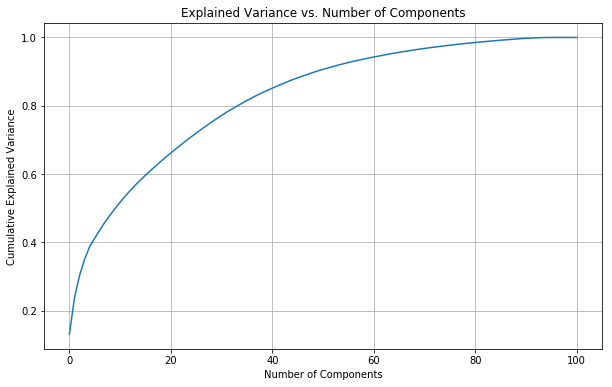

In [22]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Assuming df_scaled is your scaled DataFrame

# Apply PCA without specifying the number of components
pca = PCA()
pca.fit(df_scaled)

# Check the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(explained_variance_ratio))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid(True)
plt.show()

# Choose a suitable number of components based on the plot
# For example, if the plot shows that 95% of the variance is explained with n components, choose n

# Set the desired number of components based on your analysis
n_components = 60  # Replace with your chosen number

# Refit PCA with the selected number of components
pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

# Convert the transformed data back to a DataFrame
df_pca = pd.DataFrame(df_pca, columns=[f'PC{i+1}' for i in range(n_components)])

# Now, df_pca contains the transformed features based on the chosen number of components



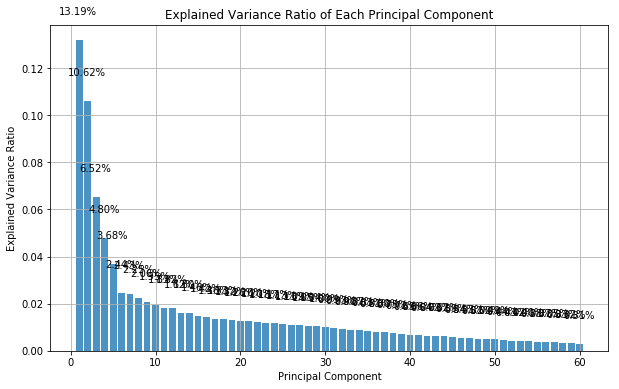

In [23]:
# Assuming df_pca is your PCA-transformed DataFrame

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Create a bar plot to visualize the explained variance of each component
plt.figure(figsize=(10, 6))
bars = plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')

# Add data labels
for bar, label in zip(bars, explained_variance_ratio):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{label:.2%}', ha='center', va='bottom')

plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Each Principal Component')
plt.grid(True)
plt.show()


In [24]:
# Assuming df_pca is your PCA-transformed DataFrame

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Determine the number of components to retain based on a threshold (e.g., 1%)
threshold = 0.01
num_components_to_retain = sum(explained_variance_ratio >= threshold)

# Retain only the components above the threshold
df_pca_filtered = df_pca.iloc[:, :num_components_to_retain]

# Display the new DataFrame with retained components
print(df_pca_filtered)


             PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0       4.417928 -3.010858 -2.618431  0.655110  0.328011  1.262252  3.230177   
1      -0.433000 -0.513897 -3.352680  1.210541 -3.130085  0.027656  0.905689   
2      -4.210727  1.987070 -1.103347 -3.306600 -1.215286 -1.441439 -1.739503   
3       0.107528 -0.662189  2.728297  1.968255  4.077538 -1.097585  0.126837   
4      -0.963189 -0.085088 -0.631520 -2.983506 -2.205194  3.179178  0.831019   
5       1.229989 -3.482335 -3.270465 -1.360694 -2.111581  0.821067 -0.392647   
6      -0.180412 -2.166492  5.076089 -0.481190 -3.003165  0.894526  1.141388   
7      -1.700919 -0.149760  1.349367  2.479888 -3.372348 -2.247816 -0.231676   
8       0.077892  0.100580 -3.551528  1.850224 -3.189484 -0.273213  2.249117   
9       2.184611  4.891284 -1.285707 -1.992422  0.280191  0.075062 -1.844865   
10     -1.669861 -1.284315  1.589525 -1.459299  0.907518  0.059356 -0.679751   
11      0.445565 -4.100478 -3.627429 -0.

### Discussion 2.2: Perform Dimensionality Reduction
After performing the initial PCA analysis I kept the top 60 features as they explained 90% of the variance.  After running the visual to see the contribution from each feature, I wrote an additional PCA script to drop anything that fell below a 1% threshold in determining variance which ultimately resulted in 30 features being retained.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

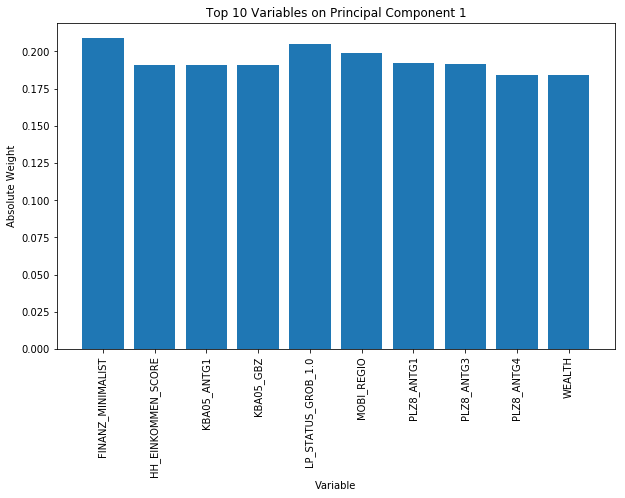

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def get_top_variable_weights(azdias_cleaned, pc_number):
    # Separate features (X)
    X = azdias_cleaned

    # Standardize the features
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(X)

    # Apply PCA
    pca = PCA(n_components=pc_number)
    df_pca = pca.fit_transform(df_scaled)

    # Get the weights of variables on the specified component
    weights = pca.components_[pc_number - 1]

    # Create a DataFrame to display the results
    weights_df = pd.DataFrame({'Variable': X.columns, 'Weight': weights})

    # Sort the DataFrame by absolute weight
    weights_df['Abs_Weight'] = np.abs(weights_df['Weight'])
    weights_df = weights_df.sort_values(by='Abs_Weight', ascending=False)

    # Print the list of variables and their respective weights
    #print(f'Top Variables on Principal Component {pc_number}:')
    #for index, row in weights_df.iterrows():
     #   print(f'{row["Variable"]}: {row["Weight"]}')

    # Plot the bar chart
    top_10_weights = weights_df.head(10)
    plt.figure(figsize=(10, 6))
    plt.bar(top_10_weights['Variable'], top_10_weights['Abs_Weight'])
    plt.xlabel('Variable')
    plt.ylabel('Absolute Weight')
    plt.title(f'Top 10 Variables on Principal Component {pc_number}')
    plt.xticks(rotation=90)
    plt.show()

# Example usage for the first principal component
get_top_variable_weights(azdias_cleaned, pc_number=1)

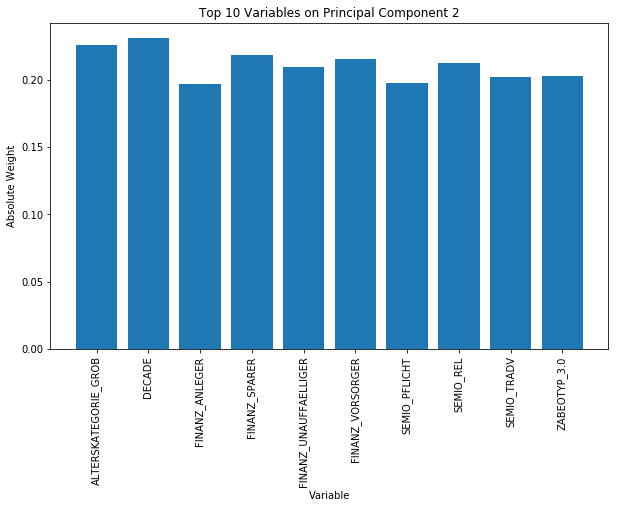

In [26]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

get_top_variable_weights(azdias_cleaned, pc_number=2)

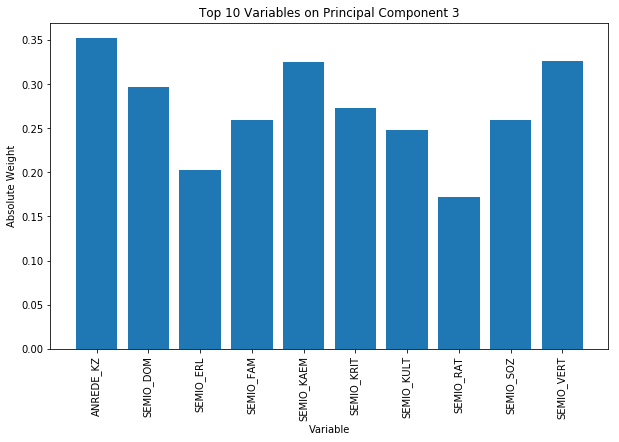

In [27]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_top_variable_weights(azdias_cleaned, pc_number=3)


### Discussion 2.3: Interpret Principal Components

It appears to me that the higher the absolute value (so either positive or negative values), the higher the contribution to the variance.  For primary cluster 1, the most important weights appear to be age and household characteristics.  PC 2 appears to be mostly based on financial data and PC 3 appears to be mostly based on social behavior.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [28]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming df_pca_filtered is your filtered PCA DataFrame

# Define a range of cluster counts
cluster_counts = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize an empty list to store average within-cluster distances
avg_distances = []

# Loop over different cluster counts
for n_clusters in cluster_counts:
    # Create a KMeans instance with the current cluster count
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Fit the model to the data
    kmeans.fit(df_pca_filtered)
    
    # Compute the average within-cluster distance (inertia_)
    avg_distance = kmeans.inertia_ / len(df_pca_filtered)
    
    # Append the result to the list
    avg_distances.append(avg_distance)

# Print the results
for n_clusters, avg_distance in zip(cluster_counts, avg_distances):
    print(f"Clusters: {n_clusters}, Average Within-Cluster Distance: {avg_distance:.2f}")

    

Clusters: 2, Average Within-Cluster Distance: 66.87
Clusters: 3, Average Within-Cluster Distance: 61.60
Clusters: 4, Average Within-Cluster Distance: 58.31
Clusters: 5, Average Within-Cluster Distance: 55.59
Clusters: 6, Average Within-Cluster Distance: 53.87
Clusters: 7, Average Within-Cluster Distance: 52.26
Clusters: 8, Average Within-Cluster Distance: 51.00
Clusters: 9, Average Within-Cluster Distance: 50.07
Clusters: 10, Average Within-Cluster Distance: 49.24


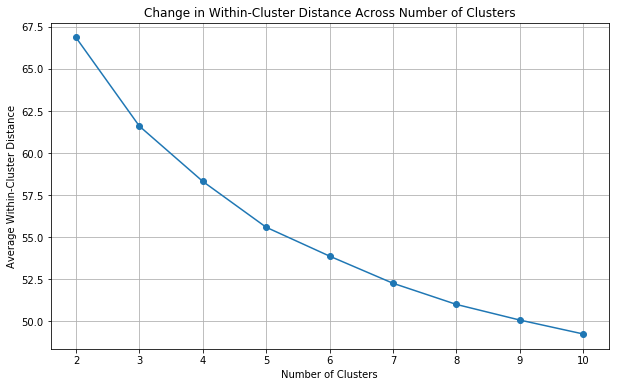

In [29]:
import matplotlib.pyplot as plt

# Assuming cluster_counts and avg_distances are obtained from the previous code

# Plot the change in within-cluster distance across the number of clusters
plt.figure(figsize=(10, 6))
plt.plot(cluster_counts, avg_distances, marker='o', linestyle='-')
plt.title('Change in Within-Cluster Distance Across Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Average Within-Cluster Distance')
plt.grid(True)
plt.show()


In [30]:
# Assuming df_pca_filtered is your filtered PCA DataFrame

# Set the selected number of clusters
optimal_clusters = 8

# Create a KMeans instance with the selected number of clusters
kmeans_selected = KMeans(n_clusters=optimal_clusters, random_state=42)

# Fit the model to the data
kmeans_selected.fit(df_pca_filtered)

# Obtain cluster predictions for the general population demographics data
pred_general = kmeans_selected.predict(df_pca_filtered)




### Discussion 3.1: Apply Clustering to General Population

I decided to divide the population into 8 clusters as this was the "elbow" point from the visualization above.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [35]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.


# Apply feature scaling using the same scaler from general demographics data
df_scaled_customer = scaler.transform(customer_cleaned)

# Apply PCA transformation using the same PCA transformer from general demographics data
df_pca_customer = pca.transform(df_scaled_customer)

df_pca_customer = pd.DataFrame(df_pca_customer, columns=[f'PC{i+1}' for i in range(n_components)])

# Calculate the explained variance ratio for each principal component
explained_variance_ratio = pca.explained_variance_ratio_

# Determine the number of components to retain based on a threshold (e.g., 1%)
threshold = 0.01
num_components_to_retain = sum(explained_variance_ratio >= threshold)

# Retain only the components above the threshold
df_pca_customer_filtered = df_pca_customer.iloc[:, :num_components_to_retain]

# Display the new DataFrame with retained components
#print(df_pca_filtered)

# Apply clustering using the same KMeans model from general demographics data
pred_customers = kmeans_selected.predict(df_pca_customer_filtered)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

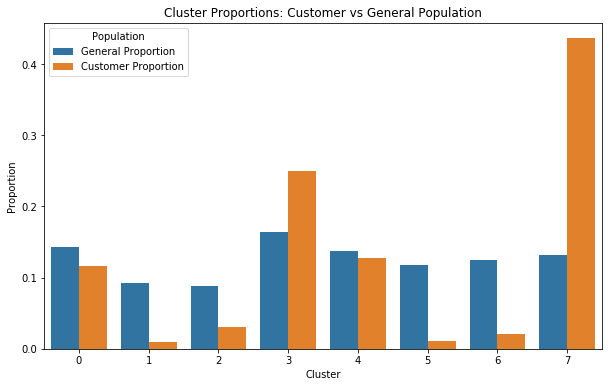

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming 'pred_general' and 'pred_customers' are your cluster predictions
# Replace them with your actual variables if they have different names

# Compute proportions
general_proportions = pd.Series(pred_general).value_counts(normalize=True).sort_index()
customer_proportions = pd.Series(pred_customers).value_counts(normalize=True).sort_index()

# Create a DataFrame for visualization
proportions_df = pd.DataFrame({
    'Cluster': general_proportions.index,
    'General Proportion': general_proportions.values,
    'Customer Proportion': customer_proportions.values
})

# Melt the DataFrame
melted_df = pd.melt(proportions_df, id_vars=['Cluster'], var_name='Population', value_name='Proportion')

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='Proportion', hue='Population', data=melted_df)
plt.title('Cluster Proportions: Customer vs General Population')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()



Cluster 5 Characteristics:
MIN_GEBAEUDEJAHR        1622.025498
GEBURTSJAHR             1415.460931
DECADE                   512.010867
KBA13_ANZAHL_PKW         365.042138
ALTER_HH                 201.555718
KBA05_GBZ                185.109751
ONLINE_AFFINITAET        168.747056
FINANZ_VORSORGER         148.305105
REGIOTYP                 138.403704
SEMIO_VERT               120.316414
KK_KUNDENTYP_3.0          79.312551
PLZ8_ANTG3                75.582718
PLZ8_GBZ                  73.628159
INNENSTADT                72.165689
LP_FAMILIE_FEIN_10.0      69.462019
PLZ8_HHZ                  69.182692
ARBEIT                    69.049395
SEMIO_RAT                 68.699114
FINANZ_ANLEGER            61.698660
SEMIO_TRADV               59.478231
LIFE_STAGE                52.526152
SEMIO_LUST                51.867463
SEMIO_ERL                 47.014112
WOHNDAUER_2008            37.852440
MOVEMENT                  36.875027
LP_STATUS_GROB_1.0        36.733255
ORTSGR_KLS9               28.724218


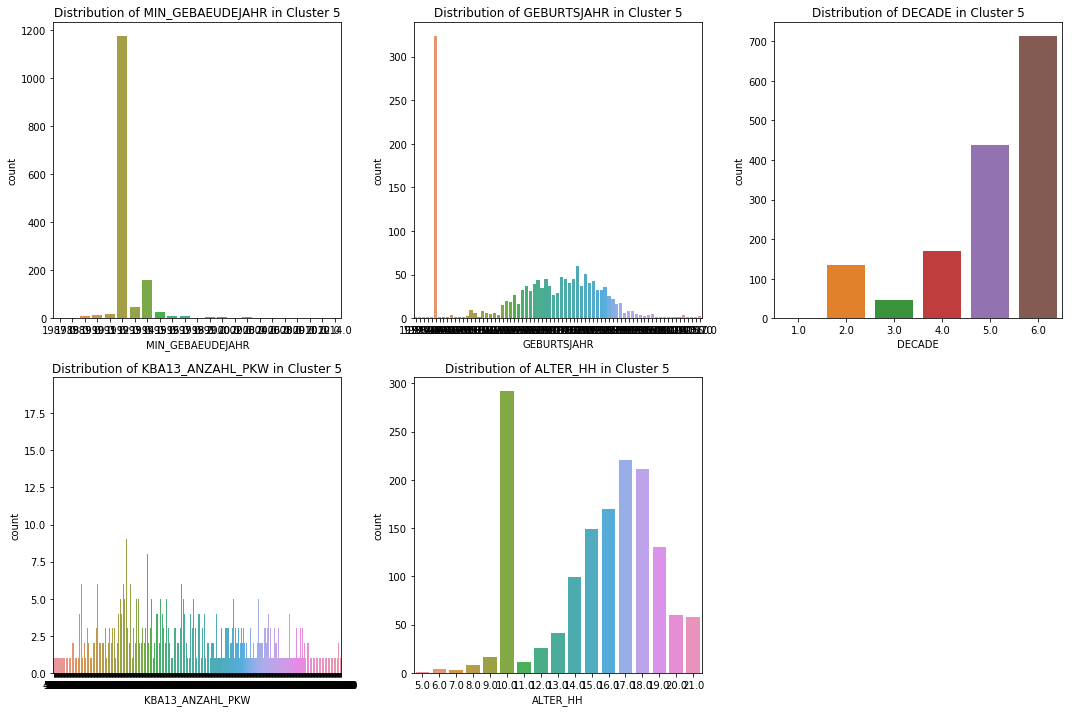

In [45]:
# Assuming 'pred_customers' contains cluster predictions for customers
# Assuming 'pca' is your PCA model

# Identify data points in Cluster 5
cluster_5_mask = pred_customers == 5

# Subset your original dataset for the data points in Cluster 5
cluster_5_data = customer_cleaned.iloc[cluster_5_mask]

# Calculate the mean or centroid in the transformed space
centroid_pca_cluster_5 = pca.transform(cluster_5_data).mean(axis=0)

# Inverse transform the centroid back to the original feature space
centroid_original = pca.inverse_transform(centroid_pca_cluster_5)

# Get the original feature weights for the components corresponding to Cluster 5
cluster_5_weights = pd.Series(centroid_original, index=azdias_cleaned.columns)

# Sort the features by their weights
cluster_5_info = cluster_5_weights.sort_values(ascending=False)

# Print the cluster 5 characteristics
print(f"\nCluster 5 Characteristics:")
print(cluster_5_info)

import seaborn as sns
import matplotlib.pyplot as plt

# Specify the top 5 features by weight
top_features = cluster_5_info.head(5).index

# Plot the distribution of each feature within Cluster 5
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, data=cluster_5_data)
    plt.title(f'Distribution of {feature} in Cluster 5')

plt.tight_layout()
plt.show()


Cluster 7 Characteristics:
MIN_GEBAEUDEJAHR        1633.097309
GEBURTSJAHR             1414.751450
DECADE                   512.372614
KBA13_ANZAHL_PKW         418.487300
ALTER_HH                 204.136390
KBA05_GBZ                187.937501
ONLINE_AFFINITAET        166.045090
FINANZ_VORSORGER         149.795186
REGIOTYP                 138.856129
SEMIO_VERT               119.355945
PLZ8_HHZ                 112.591222
PLZ8_GBZ                 108.207798
INNENSTADT                80.759437
PLZ8_ANTG3                80.110207
KK_KUNDENTYP_3.0          79.371654
LP_FAMILIE_FEIN_10.0      71.865820
SEMIO_RAT                 67.644967
ARBEIT                    66.788898
FINANZ_ANLEGER            63.383448
LIFE_STAGE                55.918845
SEMIO_TRADV               55.681881
SEMIO_LUST                53.172461
SEMIO_ERL                 45.112408
WOHNDAUER_2008            36.853190
LP_STATUS_GROB_1.0        36.171837
MOVEMENT                  35.760526
SEMIO_SOZ                 31.474149


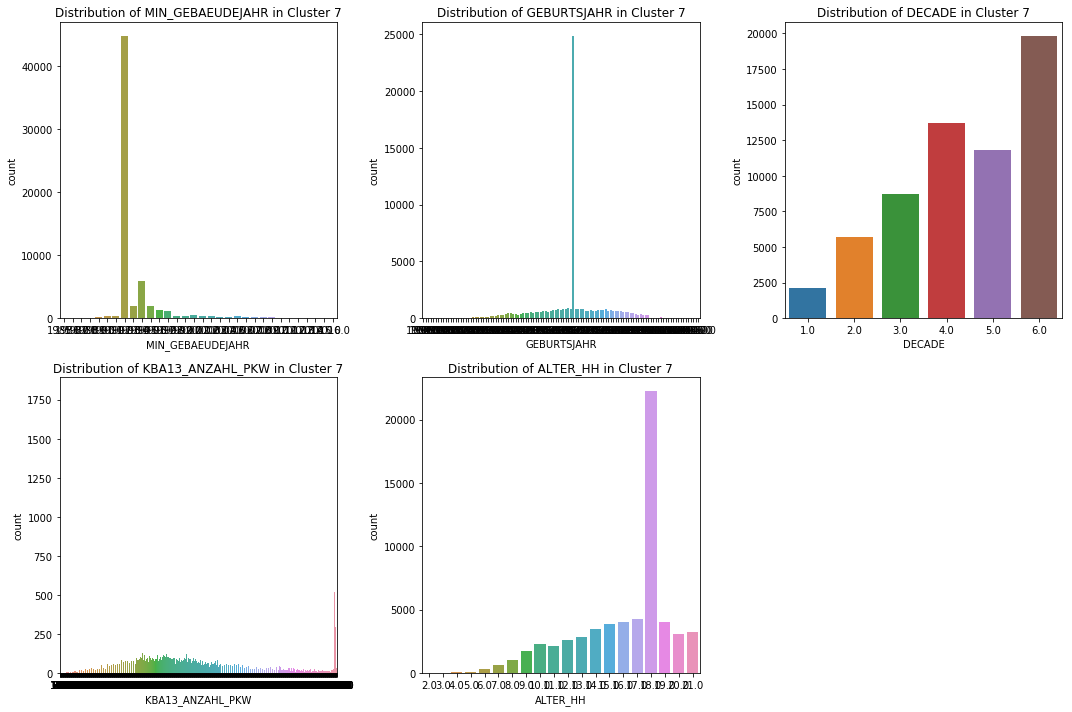

In [46]:
# Identify data points in Cluster 7
cluster_7_mask = pred_customers == 7

# Subset your original dataset for the data points in Cluster 7
cluster_7_data = azdias_cleaned.iloc[cluster_7_mask]

# Calculate the mean or centroid in the transformed space
centroid_pca_cluster_7 = pca.transform(cluster_7_data).mean(axis=0)

# Inverse transform the centroid back to the original feature space
centroid_original = pca.inverse_transform(centroid_pca_cluster_7)

# Get the original feature weights for the components corresponding to Cluster 7
cluster_7_weights = pd.Series(centroid_original, index=azdias_cleaned.columns)

# Sort the features by their weights
cluster_7_info = cluster_7_weights.sort_values(ascending=False)

# Print the cluster 7 characteristics
print(f"\nCluster 7 Characteristics:")
print(cluster_7_info)

import seaborn as sns
import matplotlib.pyplot as plt

# Specify the top 5 features by weight
top_features = cluster_7_info.head(5).index

# Plot the distribution of each feature within Cluster 7
plt.figure(figsize=(15, 10))

for i, feature in enumerate(top_features, 1):
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, data=cluster_7_data)
    plt.title(f'Distribution of {feature} in Cluster 7')

plt.tight_layout()
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

I attempted to do this and I just cannot figure out how to get the right code to answer this question.  I assume there is a way to examine the breakdown of the highest weighted features of a particular cluster and then compare that to the data dictionary to determine demographics.  I have spent countless hours on this project and have reached my breaking point of frustration. Since there's no live human to help me, I would appreciate some helpful feedback so I can complete this nightmare.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.